<a href="https://colab.research.google.com/github/AshvinVignesh/Predicting-Stock-Prices-Using-RNN/blob/main/Predicting_FB_Stock_Prices_Using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
data = pd.read_csv('FB-stock-prices.csv')
data.head()

,Date,Price
0,1/4/2021,269
1,1/5/2021,271
2,1/6/2021,263
3,1/7/2021,269
4,1/8/2021,268


In [24]:
data.shape

(251, 2)

In [25]:
data.isnull()

,Date,Price
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
246,False,False
247,False,False
248,False,False
249,False,False


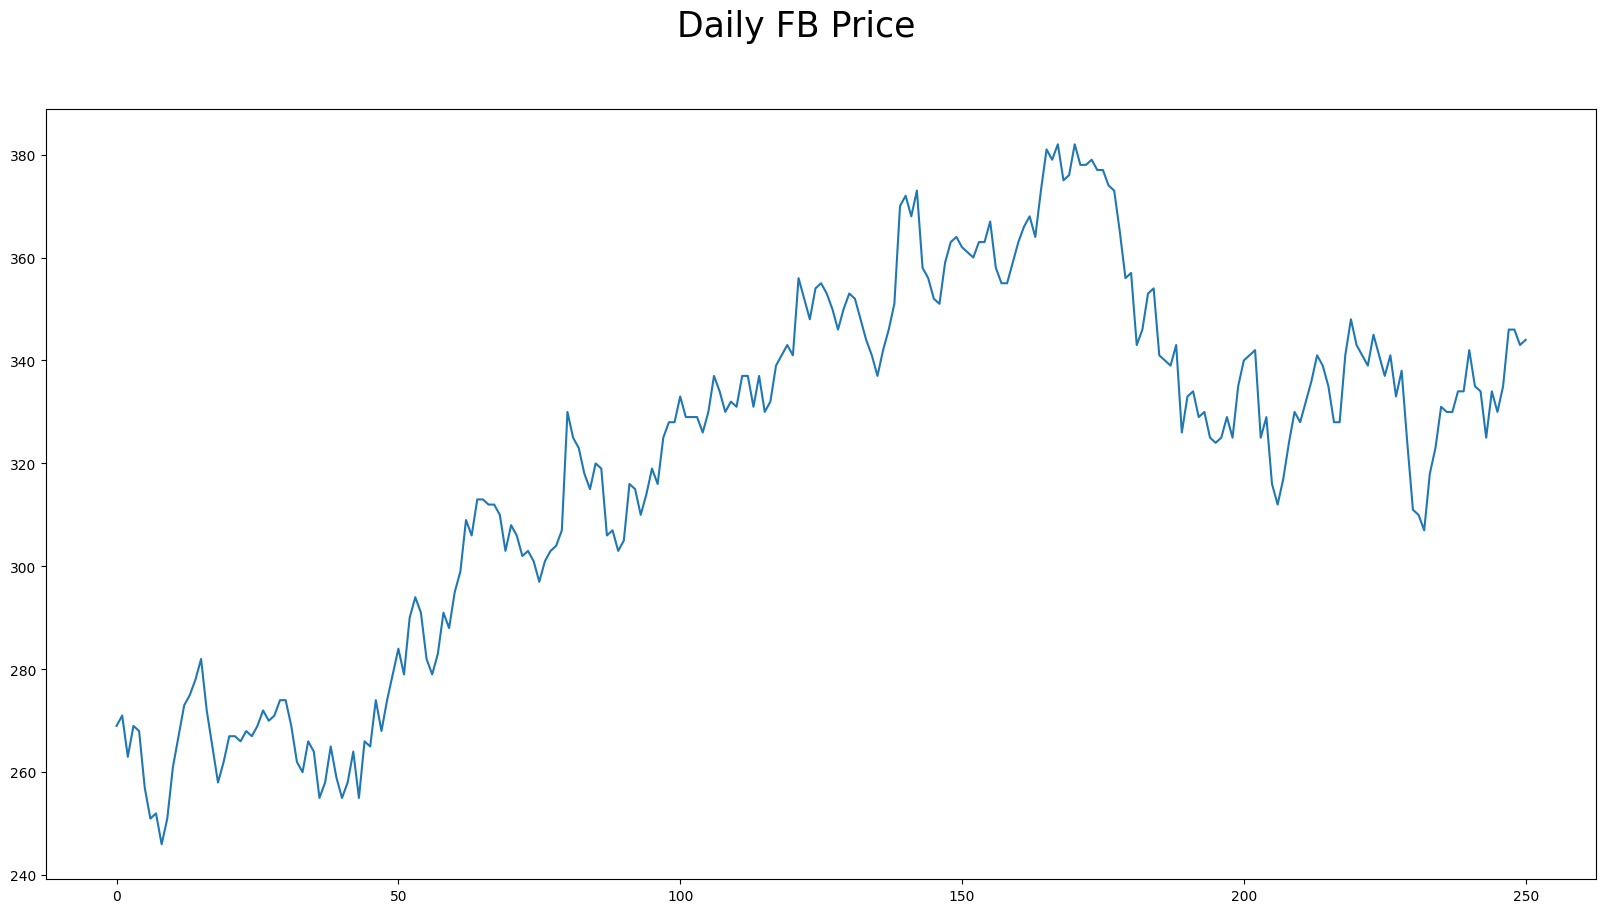

In [26]:
plt.figure(figsize=(20,10)).suptitle("Daily FB Price" , fontsize=25)
plt.plot(data["Price"])

#SPLIT DATA
For RNN we dont split randomly , but can sequentioly

In [27]:
from sklearn.preprocessing import StandardScaler

In [28]:
scaler = StandardScaler()
scaled_prices = scaler.fit_transform(data[["Price"]].values)

In [29]:
total_size = len(scaled_prices)
test_size = 50

In [30]:
train_size =total_size - test_size
print(train_size)

201


In [31]:
training_prices = scaled_prices[0:train_size,:]
test_prices =scaled_prices[train_size:,:]

In [32]:
print(training_prices.shape, test_prices.shape)

(201, 1) (50, 1)


#Create Dataset for RNN

Prepare RNN Dataset.<br> 
Each data point (X) is linked to the previous data points of size=lookback<br>
The predicted value (Y) is the next point

In [33]:
def create_rnn_dataset(data,lookback=1):
  data_x,data_y=[],[]
  for i in range(len(data) - lookback -1):
    #All points from this point, looking backwards upto lookback
    a = data[i:(i+ lookback),0]
    data_x.append(a)
    data_y.append(data[i + lookback ,0])
  return np.array(data_x) , np.array(data_y)

In [34]:
lookback =25
#Create X and Y for training
train_req_x,train_req_y = create_rnn_dataset(training_prices,lookback)

In [35]:
#Reshape for use with RNN
train_req_x = np.reshape(train_req_x, 
                         (train_req_x.shape[0],1, train_req_x.shape[1]))
print("Shapes of X, Y: ",train_req_x.shape, train_req_y.shape)

Shapes of X, Y:  (175, 1, 25) (175,)


In [36]:
from keras.models import Sequential
from keras.layers import SimpleRNN,Dense
import tensorflow as tf


In [39]:
tf.random.set_seed(3)

model= Sequential()
 
model.add(SimpleRNN(32,input_shape=(1,lookback)))

model.add(Dense(1))

#Compile with Adam Optimizer. Optimize for minimum mean square error
model.compile(loss="mean_squared_error",
                 optimizer="adam",
                 metrics=["mse"])

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 32)                1856      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,889
Trainable params: 1,889
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.fit(train_req_x, train_req_y, 
             epochs=5, batch_size=1, verbose=1)

Epoch 1/5
175/175 [==============================] - 1s 2ms/step - loss: 0.0821 - mse: 0.0821
Epoch 2/5
175/175 [==============================] - 0s 2ms/step - loss: 0.0502 - mse: 0.0502
Epoch 3/5
175/175 [==============================] - 0s 2ms/step - loss: 0.0409 - mse: 0.0409
Epoch 4/5
175/175 [==============================] - 0s 2ms/step - loss: 0.0390 - mse: 0.0390
Epoch 5/5
175/175 [==============================] - 0s 2ms/step - loss: 0.0403 - mse: 0.0403


# Test the Model

In [42]:
test_req_x,test_req_y = create_rnn_dataset(test_prices,lookback)

test_req_x = np.reshape(test_req_x, (test_req_x.shape[0],1, test_req_x.shape[1]))


In [43]:
#Evaluate the model
model.evaluate(test_req_x, test_req_y, verbose=1)

1/1 [==============================] - 0s 298ms/step - loss: 0.0576 - mse: 0.0576


[0.057571571320295334, 0.057571571320295334]

In [44]:
predict_on_test = model.predict(test_req_x)

#Inverse the scaling to view results
predict_on_test = scaler.inverse_transform(predict_on_test)

1/1 [==============================] - 0s 177ms/step


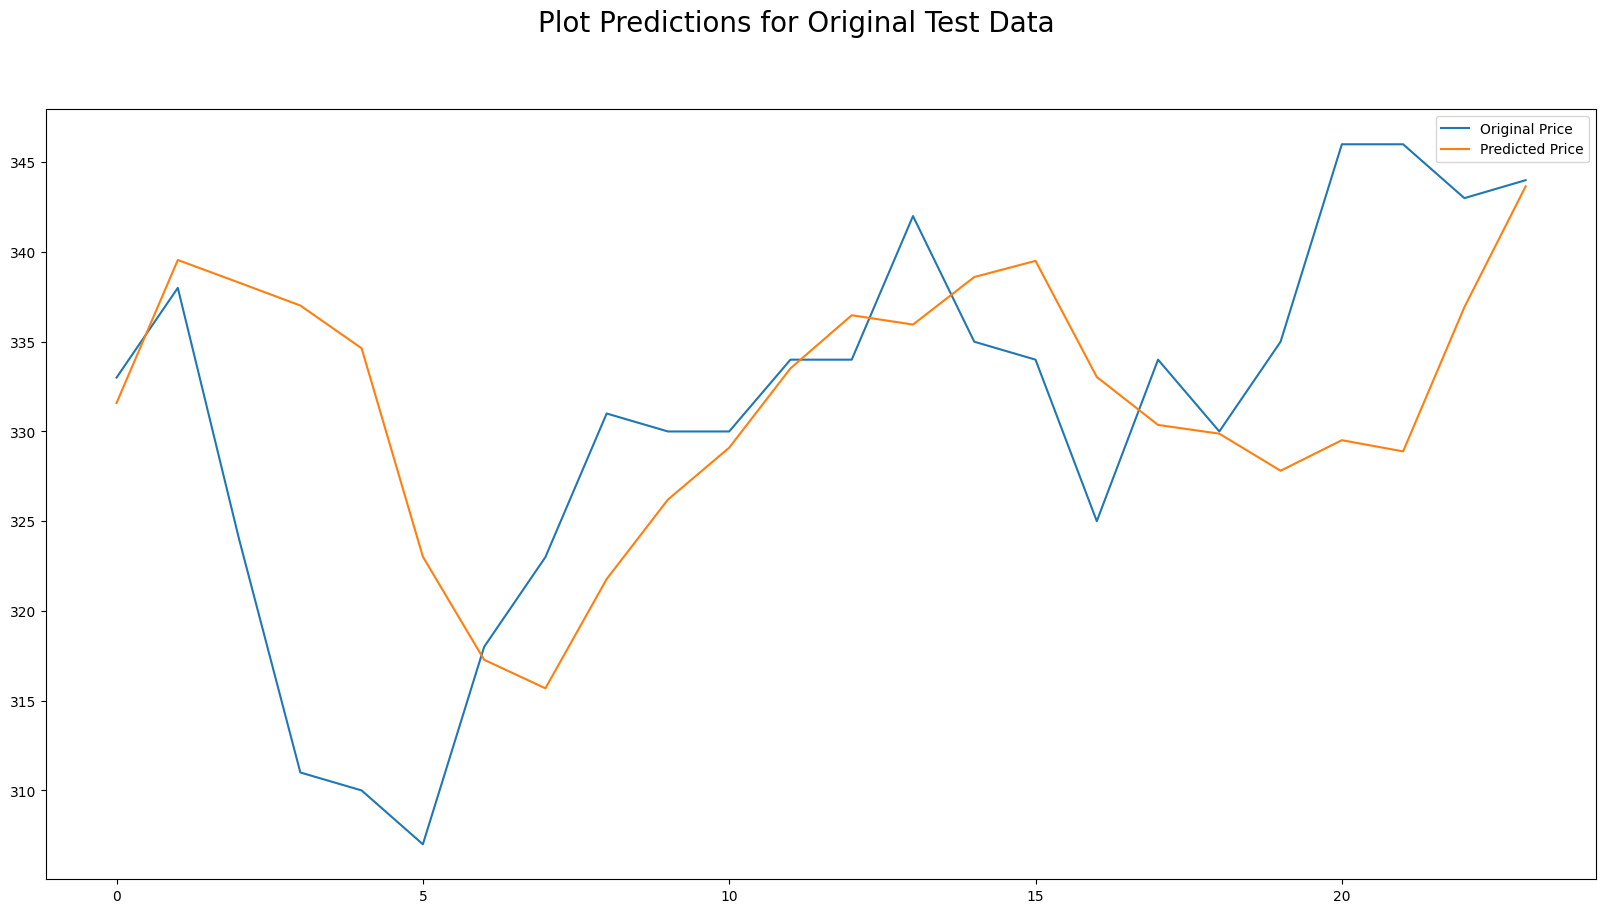

In [46]:
orig_test_values = data[["Price"]].loc[total_size-len(predict_on_test):]
orig_test_values.reset_index(drop=True, inplace=True)

plt.figure(figsize=(20,10)).suptitle("Plot Predictions for Original Test Data", fontsize=20)
plt.plot(orig_test_values, label="Original Price")
plt.plot(predict_on_test, label="Predicted Price")
plt.legend()
plt.show()

#Predictions

In [48]:
previous_prices = np.array([325,335,340,341,342,
                            325,329,316,312,317,
                            324,330,328,332,336,
                            341,339,335,328,328,
                            341,348,343,341,339])

#Scale
scaled_prices = scaler.transform(previous_prices.reshape(-1, 1))
#Reshape
model_input = np.reshape(scaled_prices, 
                         (scaled_prices.shape[1],1, scaled_prices.shape[0]))

#predictions
prediction = model.predict(model_input)

#scale back
norm_prediction = scaler.inverse_transform(prediction)

print("The predicted Stock price is :", norm_prediction[0][0])

1/1 [==============================] - 0s 32ms/step
The predicted Stock price is : 341.97955
